In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import nrrd
import json
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi
import requests
from anatomy.anatomy_api import AnatomyApi
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from scipy.optimize import curve_fit
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.graphics import utils
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison

import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

distance_threshold = 800
overlap_threshold = 0.05

In /opt/anaconda3/envs/DMN/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/envs/DMN/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/envs/DMN/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/anaconda3/envs/DMN/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/envs/DMN/lib/python3.7/site-packages/m

In [2]:
aapi = AnatomyApi()
ss = aapi.get_summary_structure_data('id')
mcc = MouseConnectivityCache(manifest_file = 'connectivity/mouse_connectivity_manifest.json')
structure_tree = mcc.get_structure_tree()
isocortex = structure_tree.get_structures_by_acronym(['Isocortex'])[0]
cla = structure_tree.get_structures_by_acronym(['CLA'])[0]['id']
HPF = structure_tree.get_structures_by_acronym(['HPF'])[0]
iso = structure_tree.descendant_ids([isocortex['id']])[0]
iso = [structure for structure in iso if structure in ss]
hipp = structure_tree.descendant_ids([HPF['id']])[0]
hipp = [structure for structure in hipp if structure in ss]
ia_map = structure_tree.get_id_acronym_map()
ai_map = {value:key for key, value in ia_map.items()}
ctx_strs = [ai_map[structure] for structure in iso]
hipp_strs = [ai_map[structure] for structure in hipp]
valid_strs = ctx_strs#+hipp_strs #No Cla

In [3]:
datpath = r'../data_files'
imagepath = basepath = r'../images'
path = r'../../../'
savepath = os.path.join(path, '_final_figures', 'Figure_S6')
full_td_dataset = pd.read_csv(os.path.join(datpath, 'target_defined_dataset.csv'))
td_dataset = full_td_dataset[full_td_dataset['include'] == 'yes']
td_dataset = td_dataset[td_dataset['source'].isin(valid_strs)]
td_dataset = td_dataset[td_dataset['target_by_polygon'] != 'POST']
print(len(td_dataset['source'].unique()))
print(len(full_td_dataset))
print(len(td_dataset))
print(len(td_dataset['source'].unique()))

25
183
121
25


In [4]:
# including primary/secondary switch matches within 500 um, all others no distance or overlap constraint
alldat = pd.read_csv(os.path.join(datpath, 'td_wt_cre_matched_correlations_NPV.csv'))
print(len(alldat))
alldat = alldat[alldat['image_series_id'].isin(td_dataset['image_series_id'].unique())]
print(len(alldat))
c_by_source = pd.read_csv(os.path.join(datpath, 'match_correlations_by_source_NPV_all_thresholded_1_5.csv'))
c_by_source = c_by_source[c_by_source['same_primary'] == True]
c_by_source = c_by_source[c_by_source['same secondary for <60% primary'] != False]
alldat = alldat[alldat['same_primary'] == True]
alldat = alldat[alldat['same secondary for <60% primary'] != False]
print(len(alldat))
print(len(c_by_source))

5087
3193
1323
3077


In [5]:
# check for duplicates
c_by_source['index_original'] = c_by_source.groupby(['match_A', 'match_B']).match_A.transform('idxmin')    
c_by_source = c_by_source[~c_by_source.duplicated(subset=['match_A', 'match_B'], keep='first')]
for isid in c_by_source['match_A'].unique():
    Bmatches = c_by_source[c_by_source['match_A'] == isid]['match_B'].values
    Amatches = c_by_source[c_by_source['match_B'] == isid]['match_A'].values
    duplicates = [match for match in Amatches if match in Bmatches]
    if len(duplicates) > 0:
        print(Bmatches)
        print(Amatches)

In [6]:
# experiments with leakage, tile edges, low GFP signal, surface artifacts, wrong injection site assigned,
# or not all layers labeled, looks like PT cells only
alldat = alldat.merge(td_dataset[['image_series_id', 'include', 'CAV_percent_DMN']], 
                      on='image_series_id', how = 'left')
fail_expts = [114008926, 120280939, 180073473, 180403712, 180601025, 183174303, 183329222,
              249396394, 296047806, 299446445, 301060890, 303784745, 480069939, 482578964, 
              506947040, 514333422, 525796603, 545428296, 559878074, 638314843, 182888003,
             304585910, 183171679, 272930013, 523718075, 517072832, 148964212, 304762965,
             566992832, 272930013, 304762965, 266250904, 114399224, 286483411, 286417464,
             593277684, 546103149, 642809043, 286483411, 304564721] #VISp outlier excluded
alldat = alldat[~alldat['match_id'].isin(fail_expts)]
c_by_source = c_by_source[~c_by_source['match_A'].isin(fail_expts)]
c_by_source = c_by_source[~c_by_source['match_B'].isin(fail_expts)]
print(len(c_by_source))
print(len(alldat))

2348
1187


In [7]:
# Remove thalamus and hippocampus proper sources for this analysis
c_by_source = c_by_source[(c_by_source['match_A_primary_source'].isin(valid_strs)) |
                    (c_by_source['match_B_primary_source'].isin(valid_strs))]
c_by_source['source'] = c_by_source['match_A_primary_source']
c_by_source = c_by_source[~c_by_source['source'].isin(['CA1', 'CA3', 'DG', 'SUB',
                                                      'ENTl', 'ENTm'])]
alldat = alldat[~alldat['source'].isin(['CA1', 'CA3', 'DG', 'ENTl', 'ENTm', 'SUB'])]
print(len(c_by_source))
print('target-defined experiments meeting criteria')
print(len(alldat))
print(len(alldat['match_id'].unique()))

2112
target-defined experiments meeting criteria
1187
157


## Use ANOVA to find significant factors affecting correlation

In [8]:
results = ols('spearman_correlation ~ match_A_injection_size+match_B_injection_size+distance+dice_coefficient',
              c_by_source).fit()
aov_table = sm.stats.anova_lm(results)
aov_table


,df,sum_sq,mean_sq,F,PR(>F)
match_A_injection_size,1.0,0.688114,0.688114,69.715326,1.224175e-16
match_B_injection_size,1.0,0.087783,0.087783,8.893630,2.894496e-03
distance,1.0,16.160589,16.160589,1637.287144,2.267806e-265
dice_coefficient,1.0,0.022064,0.022064,2.235417,1.350300e-01
Residual,2107.0,20.796817,0.009870,NaN,NaN


In [9]:
# Clearly distance is the most important factor. Apply distance threshold
alldat = alldat[alldat['distance'] < distance_threshold]
c_by_source = c_by_source[c_by_source['distance'] < distance_threshold]
print(len(alldat))
print(len(c_by_source))

991
946


In [10]:
results = ols('spearman_correlation ~ match_A_injection_size+match_B_injection_size+distance+dice_coefficient', 
              c_by_source).fit()
aov_table = sm.stats.anova_lm(results)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
match_A_injection_size,1.0,0.231509,0.231509,44.367658,4.623165e-11
match_B_injection_size,1.0,0.002830,0.002830,0.542316,4.616579e-01
distance,1.0,0.356986,0.356986,68.414747,4.492834e-16
dice_coefficient,1.0,0.204537,0.204537,39.198640,5.811102e-10
Residual,941.0,4.910106,0.005218,NaN,NaN


In [11]:
# apply overlap threshold
c_by_source = c_by_source[c_by_source['dice_coefficient'] > overlap_threshold]
alldat = alldat[alldat['dice'] > overlap_threshold]
print(len(alldat))
print(len(alldat['image_series_id'].unique()))
print(len(c_by_source))

586
110
627


In [12]:
results = ols('spearman_correlation ~ match_A_injection_size+match_B_injection_size+distance+dice_coefficient', c_by_source).fit()
aov_table = sm.stats.anova_lm(results)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
match_A_injection_size,1.0,0.091826,0.091826,19.749220,0.000010
match_B_injection_size,1.0,0.006407,0.006407,1.377953,0.240899
distance,1.0,0.088675,0.088675,19.071510,0.000015
dice_coefficient,1.0,0.104951,0.104951,22.572022,0.000003
Residual,622.0,2.892051,0.004650,NaN,NaN


In [13]:
results = ols('spearman_correlation ~ match_A_injection_size*distance*dice_coefficient', 
              c_by_source).fit()
aov_table = sm.stats.anova_lm(results)
aov_table
# No interaction terms are significant

,df,sum_sq,mean_sq,F,PR(>F)
match_A_injection_size,1.0,0.091826,0.091826,19.533409,0.000012
distance,1.0,0.085921,0.085921,18.277371,0.000022
match_A_injection_size:distance,1.0,0.002928,0.002928,0.622898,0.430275
dice_coefficient,1.0,0.084490,0.084490,17.972940,0.000026
match_A_injection_size:dice_coefficient,1.0,0.000169,0.000169,0.035900,0.849783
distance:dice_coefficient,1.0,0.005835,0.005835,1.241294,0.265654
match_A_injection_size:distance:dice_coefficient,1.0,0.002839,0.002839,0.604016,0.437347
Residual,619.0,2.909901,0.004701,NaN,NaN


In [14]:
results = ols('spearman_correlation ~ match_A_injection_size+distance+dice_coefficient', 
              c_by_source).fit()
aov_table = sm.stats.anova_lm(results)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
match_A_injection_size,1.0,0.091826,0.091826,19.588514,0.000011
distance,1.0,0.085921,0.085921,18.328933,0.000022
dice_coefficient,1.0,0.085697,0.085697,18.281063,0.000022
Residual,623.0,2.920466,0.004688,NaN,NaN


In [15]:
wt = []
emx = []
emxs = []
rbp = []
rbps = []
for isid in td_dataset['image_series_id']:
    wt.append(len(alldat[(alldat['image_series_id'] == isid) &
                        (alldat['transgenic_line'].isnull())]))
    emx.append(len(alldat[(alldat['image_series_id'] == isid) &
                          (alldat['transgenic_line'] == 'Emx1-IRES-Cre') &
                          (alldat['Virus'] == 'EGFP')]))
    emxs.append(len(alldat[(alldat['image_series_id'] == isid) &
                          (alldat['transgenic_line'] == 'Emx1-IRES-Cre') &
                          (alldat['Virus'] == 'SypEGFP')]))
    rbp.append(len(alldat[(alldat['image_series_id'] == isid) &
                          (alldat['transgenic_line'] == 'Rbp4-Cre_KL100') &
                          (alldat['Virus'] == 'EGFP')]))
    rbps.append(len(alldat[(alldat['image_series_id'] == isid) &
                          (alldat['transgenic_line'] == 'Rbp4-Cre_KL100') &
                          (alldat['Virus'] == 'SypEGFP')]))
matches = pd.DataFrame({'image_series_id': td_dataset['image_series_id'], 'wt': wt, 'Emx1': emx,
                       'Emx1_Syp': emxs, 'Rbp4': rbp, 'Rbp4_Syp': rbps})
matches['total'] = matches[['wt', 'Emx1', 'Emx1_Syp', 'Rbp4', 'Rbp4_Syp']].sum(axis = 1)

In [16]:
len(matches[matches['total'] == 0])

11

## Counts for control dataset

In [17]:
wt = c_by_source[c_by_source['transgenic_line_A'].isnull()]['match_A'].unique()
wt2 = c_by_source[c_by_source['transgenic_line_B'].isnull()]['match_B'].unique()
wt = np.append(wt, wt2)
print('wt: ', len(np.unique(wt)))
Emx = c_by_source[c_by_source['transgenic_line_A'] == 'Emx1-IRES-Cre']['match_A'].unique()
Emx2 = c_by_source[c_by_source['transgenic_line_B'] == 'Emx1-IRES-Cre']['match_B'].unique()
Emx = np.append(Emx, Emx2)
print('Emx1-Cre: ', len(np.unique(Emx)))
Rbp4 = c_by_source[c_by_source['transgenic_line_A'] == 'Rbp4-Cre_KL100']['match_A'].unique()
Rbp42 = c_by_source[c_by_source['transgenic_line_B'] == 'Rbp4-Cre_KL100']['match_B'].unique()
Rbp4 = np.append(Rbp4, Rbp42)
print('Rbp4-Cre: ', len(np.unique(Rbp4)))
other = c_by_source[(~c_by_source['transgenic_line_A'].isnull()) & 
                    (~c_by_source['transgenic_line_A'].isin(['Emx1-IRES-Cre', 'Rbp4-Cre_KL100']))]['match_A'].unique()
other2 = c_by_source[(~c_by_source['transgenic_line_B'].isnull()) & 
                    (~c_by_source['transgenic_line_B'].isin(['Emx1-IRES-Cre', 'Rbp4-Cre_KL100']))]['match_B'].unique()
other = np.append(other, other2)
print('other: ', len(np.unique(other)))

wt:  88
Emx1-Cre:  53
Rbp4-Cre:  67
other:  0


In [18]:
Emx = c_by_source[(c_by_source['transgenic_line_A'] == 'Emx1-IRES-Cre') &
                 (c_by_source['Virus_A'] == 'SypEGFP')]['match_A'].unique()
Emx2 = c_by_source[(c_by_source['transgenic_line_B'] == 'Emx1-IRES-Cre') &
                  (c_by_source['Virus_B'] == 'SypEGFP')]['match_B'].unique()
Emx = np.append(Emx, Emx2)
print('Emx1-Cre: ', len(np.unique(Emx)))
Rbp4 = c_by_source[(c_by_source['transgenic_line_A'] == 'Rbp4-Cre_KL100') &
                  (c_by_source['Virus_A'] == 'SypEGFP')]['match_A'].unique()
Rbp42 = c_by_source[(c_by_source['transgenic_line_B'] == 'Rbp4-Cre_KL100') &
                   (c_by_source['Virus_B'] == 'SypEGFP')]['match_B'].unique()
Rbp4 = np.append(Rbp4, Rbp42)
print('Rbp4-Cre: ', len(np.unique(Rbp4)))

Emx1-Cre:  27
Rbp4-Cre:  13


In [19]:
print(len(c_by_source[c_by_source['same secondary for <60% primary'] == True]))

69


In [20]:
len([structure for structure in c_by_source['source'].unique() if structure in ctx_strs])

27

In [21]:
len(ctx_strs)

43

In [22]:
len([structure for structure in c_by_source[
    c_by_source['same secondary for <60% primary'] == True][
    'match_A_secondary_source'].unique() 
     if structure in ctx_strs and structure not in c_by_source['source'].unique()])

7

In [23]:
[structure for structure in c_by_source[
    c_by_source['same secondary for <60% primary'] == True][
    'match_A_secondary_source'].unique() 
     if structure in ctx_strs and structure not in c_by_source['source'].unique()]

['VISli', 'RSPd', 'ILA', 'FRP', 'TEa', 'VISa', 'AIp']

In [24]:
c_by_source['source'].unique()

array(['AUDp', 'VISl', 'VISp', 'VISpm', 'SSp-n', 'SSs', 'SSp-bfd', 'MOs',
       'ACAd', 'PL', 'ORBvl', 'VISrl', 'SSp-ll', 'SSp-ul', 'MOp', 'ACAv',
       'AUDpo', 'VISpor', 'VISam', 'ORBl', 'RSPv', 'SSp-tr', 'RSPagl',
       'SSp-m', 'AUDd', 'VISC', 'VISal'], dtype=object)

In [25]:
print([structure for structure in c_by_source[c_by_source['same secondary for <60% primary'] == 'TRUE'][
    'match_A_secondary_source'].unique() 
     if structure in ctx_strs and structure not in c_by_source['source'].unique()])

[]


In [26]:
c_by_source.groupby('source')['distance'].count()

source
ACAd        22
ACAv         3
AUDd         1
AUDp         4
AUDpo        3
MOp          4
MOs         16
ORBl         3
ORBvl        3
PL           1
RSPagl       5
RSPv         8
SSp-bfd     14
SSp-ll       7
SSp-m        5
SSp-n        7
SSp-tr       1
SSp-ul       1
SSs          3
VISC         3
VISal        2
VISam        9
VISl        19
VISp       429
VISpm       10
VISpor      38
VISrl        6
Name: distance, dtype: int64

In [27]:
c_by_source.groupby('match_B')['distance'].count().max()

27

## Counts for target-defined dataset

In [28]:
print(len(alldat))
print(len(alldat['match_id'].unique()))

586
128


In [29]:
len([isid for isid in td_dataset['image_series_id'].values if 
     isid not in alldat['image_series_id'].values])

11

In [30]:
wt = alldat[alldat['transgenic_line'].isnull()]['match_id'].unique()
print('wt: ', len(np.unique(wt)))
Emx = alldat[alldat['transgenic_line'] == 'Emx1-IRES-Cre']['match_id'].unique()
print('Emx1-Cre: ', len(np.unique(Emx)))
Rbp4 = alldat[alldat['transgenic_line'] == 'Rbp4-Cre_KL100']['match_id'].unique()
print('Rbp4-Cre: ', len(np.unique(Rbp4)))
other = alldat[(~alldat['transgenic_line'].isnull()) & 
                    (~alldat['transgenic_line'].isin(['Emx1-IRES-Cre', 'Rbp4-Cre_KL100']))]['match_id'].unique()
print('other: ', len(np.unique(other)))

wt:  49
Emx1-Cre:  37
Rbp4-Cre:  42
other:  0


In [31]:
Emx = alldat[(alldat['transgenic_line'] == 'Emx1-IRES-Cre') &
                 (alldat['Virus'] == 'SypEGFP')]['match_id'].unique()
print('Emx1-Cre: ', len(np.unique(Emx)))
Rbp4 = alldat[(alldat['transgenic_line'] == 'Rbp4-Cre_KL100') &
                  (alldat['Virus'] == 'SypEGFP')]['match_id'].unique()
print('Rbp4-Cre: ', len(np.unique(Rbp4)))

Emx1-Cre:  19
Rbp4-Cre:  10


In [32]:
#slope, intercept, r_value, p_value, std_error 
m, b, r1, p1, se = stats.linregress(c_by_source['match_B_injection_size'], c_by_source['spearman_correlation'])
m, b, r2, p2, se = stats.linregress(c_by_source['match_A_injection_size'], c_by_source['spearman_correlation'])
m, b, r3, p3, se = stats.linregress(c_by_source['distance'], c_by_source['spearman_correlation'])
m, b, r4, p4, se = stats.linregress(c_by_source['dice_coefficient'], 
                                    c_by_source['spearman_correlation'])
m, b, r6, p6, se = stats.linregress(alldat['td_injection_size'], 
                                    alldat['spearman_correlation'])
m, b, r7, p7, se = stats.linregress(alldat['match_injection_size'], 
                                    alldat['spearman_correlation'])
m, b, r8, p8, se = stats.linregress(alldat['distance'], 
                                    alldat['spearman_correlation'])
m, b, r9, p9, se = stats.linregress(alldat['dice'], 
                                    alldat['spearman_correlation'])

fdrcorr = sm.stats.fdrcorrection([p1, p2, p3, p4, p6, p7, p8, p9], alpha=0.05, method='indep')
print(fdrcorr)
print(r1)
print(r2)
print(r3)
print(r4)
print(r6)
print(r7)
print(r8)
print(r9)

(array([ True,  True,  True,  True,  True,  True,  True,  True]), array([1.59465881e-03, 3.82230511e-05, 4.15226231e-05, 2.46990005e-09,
       5.90363118e-07, 1.61683208e-03, 3.31906532e-03, 1.68957538e-09]))
0.12910226342895045
0.169825299303595
-0.16713634694711907
0.24379079510063453
0.21201635160452317
-0.1315524623648732
-0.12111868857201583
0.25851669630970386


In [33]:
#slope, intercept, r_value, p_value, std_error 
m, b, r2, p2, se = stats.linregress(c_by_source['match_A_injection_size'], 
                                    c_by_source['spearman_correlation'])
m, b, r3, p3, se = stats.linregress(c_by_source['distance'], 
                                    c_by_source['spearman_correlation'])
m, b, r4, p4, se = stats.linregress(c_by_source['dice_coefficient'], 
                                    c_by_source['spearman_correlation'])

fdrcorr = sm.stats.fdrcorrection([p2, p3, p4], alpha=0.05, method='indep')
print(fdrcorr)
print(r2)
print(r3)
print(r4)

(array([ True,  True,  True]), array([2.59516394e-05, 2.59516394e-05, 1.85242504e-09]))
0.169825299303595
-0.16713634694711907
0.24379079510063453


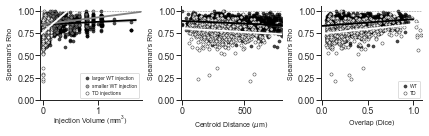

In [34]:
fig, ax = plt.subplots(1, 3, figsize = (6, 2), sharey = False)
sns.regplot('match_B_injection_size', 'spearman_correlation', 
            data = c_by_source, ax = ax[0], color = 'k',
           marker = '.', 
            scatter_kws={'edgecolors':'k',
                        'linewidth':0.5,
                        's': 40,
                        'alpha': 0.7,
                        'rasterized':True},
            label = 'larger WT injection')
sns.regplot('match_A_injection_size', 'spearman_correlation', data = c_by_source, 
            ax = ax[0], color = 'gray',
           marker = '.', ci=False, 
            scatter_kws={'edgecolors':'k',
                        'linewidth':0.5,
                        's': 40,
                        'alpha': 0.7,
                        'rasterized':True},
            label = 'smaller WT injection')
sns.regplot('td_injection_size', 'spearman_correlation', 
            data = alldat, ax = ax[0], 
            ci = False, 
            color = 'w', marker = '.', 
            scatter_kws={'edgecolors':'k',
                        'linewidth':0.5,
                        's': 40,
                        'alpha': 0.8,
                        'rasterized':True},
           label = 'TD injections')
sns.regplot('distance', 'spearman_correlation', data = c_by_source, ax = ax[1], color = 'k', 
            marker = '.', 
            scatter_kws={'edgecolors':'k',
                        'linewidth':0.5,
                        's': 40,
                        'alpha': 0.7,
                        'rasterized':True},
            label = 'WT')
sns.regplot('distance', 'spearman_correlation', 
            data = alldat, ax = ax[1], color = 'w', 
            marker = '.', 
            scatter_kws={'edgecolors':'k',
                        'linewidth':0.5,
                        's': 40,
                        'alpha': 0.8,
                        'rasterized':True},
            label = 'TD')
sns.regplot('dice_coefficient', 'spearman_correlation', data = c_by_source, ax = ax[2],
           color = 'k', marker = '.', 
            scatter_kws={'edgecolors':'k',
                        'linewidth':0.5,
                        's': 40,
                        'alpha': 0.7,
                        'rasterized':True},
            label = 'WT')
sns.regplot('dice', 'spearman_correlation', 
            data = alldat, ax = ax[2],
           color = 'w', marker = '.', 
            scatter_kws={'edgecolors':'k',
                        'linewidth':0.5,
                        's': 40,
                        'alpha': 0.8,
                        'rasterized':True},
            label = 'TD')
#ax[0].set_xscale('log')
ax[0].set_ylim([0,1.05])
ax[1].set_ylim([0,1.05])
ax[2].set_ylim([0,1.05])
ax[0].set_xlim([-0.05, 1.8])
ax[1].set_xlim([-10, 800])
ax[2].set_xlim([-0.01, 1.1])
ax[0].axhline(y=1, color = 'gray', linestyle = '--', linewidth = 0.5)
ax[1].axhline(y=1, color = 'gray', linestyle = '--', linewidth = 0.5)
ax[2].axhline(y=1, color = 'gray', linestyle = '--', linewidth = 0.5)
sns.despine()
ax[0].tick_params(top = False, right = False, bottom=True, left=True, pad=1)
ax[1].tick_params(top = False, right = False, bottom=True, left=True, pad=1)
ax[2].tick_params(top = False, right = False, bottom=True, left=True, pad=1)
ax[0].set_ylabel('Spearman\'s Rho', fontsize = 7)
ax[1].set_ylabel('Spearman\'s Rho', fontsize = 7)
ax[2].set_ylabel('Spearman\'s Rho', fontsize = 7)
ax[0].set_xlabel(r'Injection Volume (mm$\mathregular{^{3}}$)', fontsize = 7)
ax[1].set_xlabel('Centroid Distance ($\mu$m)', fontsize = 7)
ax[2].set_xlabel('Overlap (Dice)', fontsize = 7)
ax[0].legend(loc = 4, fontsize = 5, handletextpad = 0)
ax[2].legend(loc = 4, fontsize = 5, handletextpad = 0)
ax[0].xaxis.labelpad = -2
ax[1].xaxis.labelpad = 3
plt.subplots_adjust(hspace=0.01)
plt.tight_layout()
#plt.savefig(os.path.join(savepath, 'dependence of corr on size distance overlap.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [35]:
plot_order = ['ACAd', 'ACAv', 'PL', 'ILA', 'ORBl','ORBm', 'ORBvl', 
              'VISa',  'VISam', 'RSPd', 'RSPv', 'RSPagl', 
              'MOs', 'SSp-tr', 'SSp-ll', 'SSp-m', 'SSp-n', 'SSp-bfd', 
              'SSp-ul','SSs',  'MOp', 'VISC',  
              'ECT', 'VISal', 'VISl', 'VISp', 'VISpor', 'VISli', 
              'VISrl', 'VISpm', 'AUDd', 'AUDp', 'AUDpo',
              'ENTl', 'ENTm']

In [36]:
print([source for source in c_by_source['source'].unique() if source not in plot_order])
print([source for source in plot_order if source not in c_by_source['source'].unique()])
print([source for source in alldat['source'].unique() if source not in plot_order])
print([source for source in plot_order if source not in alldat['source'].unique()])

[]
['ILA', 'ORBm', 'VISa', 'RSPd', 'ECT', 'VISli', 'ENTl', 'ENTm']
[]
['SSp-m', 'SSp-n', 'SSp-bfd', 'SSp-ul', 'SSs', 'MOp', 'VISC', 'VISal', 'AUDd', 'AUDp', 'AUDpo', 'ENTl', 'ENTm']


In [37]:
alldat_in = alldat[alldat['CAV_percent_DMN'] > 50]
alldat_out = alldat[alldat['CAV_percent_DMN'] < 50]

In [38]:
pltdat = c_by_source.groupby('source')['distance'].count().reset_index().merge(
    alldat_in.groupby('source')['distance'].count().reset_index()[[
        'source', 'distance']], on = 'source', how = 'outer') # just need a column to count, not actaually plotting correlation
pltdat = pltdat.merge(
    alldat_out.groupby('source')['distance'].count().reset_index()[[
        'source', 'distance']], on = 'source', how = 'outer')
pltdat.rename(columns = {'distance_x': 'WT', 'distance_y': 'TD-in', 'distance': 'TD-out'})
pltdat.index = pltdat['source']
pltdat.drop(columns = {'source'}, inplace = True)
#pltdat.to_csv(os.path.join(savepath, 'number_of_experiments_by_type.csv'))

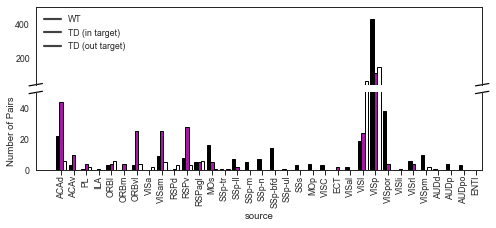

In [39]:
pltdat = c_by_source.groupby('source')['distance'].count().reset_index().merge(
    alldat_in.groupby('source')['distance'].count().reset_index()[[
        'source', 'distance']], on = 'source', how = 'outer') # just need a column to count, not actaually plotting correlation
pltdat = pltdat.merge(
    alldat_out.groupby('source')['distance'].count().reset_index()[[
        'source', 'distance']], on = 'source', how = 'outer')
pltdat.rename(columns = {'distance_x': 'WT', 'distance_y': 'TD-in', 'distance': 'TD-out'})
pltdat = pltdat.melt(id_vars = 'source', var_name = 'Dataset', value_name = 'count')
f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize = (8, 3))
    # plot the same data on both axes

sns.barplot('source', 'count', data = pltdat, ax = ax, hue = 'Dataset', 
            order = plot_order, palette = ['k', 'm', 'w'], edgecolor = 'k',
           linewidth = 1)
sns.barplot('source', 'count', data = pltdat, ax = ax2, hue = 'Dataset', 
            order = plot_order, palette = ['k', 'm', 'w'], edgecolor = 'k',
           linewidth = 1)

break_point = 50
ax.set_ylim(break_point, 500)  # top half
ax2.set_ylim(0, break_point)  # bottom half

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax.tick_params(top = False, bottom = False, pad = 1)  # don't put tick labels at the top
ax.tick_params(top=False, bottom = False, right=False)
ax2.spines['top'].set_visible(False)
ax2.tick_params(top=False, right = False, bottom = False, pad = 1)
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
f.subplots_adjust(hspace=0.1)
ax2.set_xlabel("source")
ax.set_xlabel("")
ax.set_ylabel("")
ax.legend(frameon = False, labels = ['WT', 'TD (in target)', 'TD (out target)'])
ax2.legend_.remove()
plt.ylabel('Number of Pairs');
plt.setp( ax2.xaxis.get_majorticklabels(), rotation=90 );
#plt.savefig(os.path.join(savepath, 'number_of_pairs_in_datasets_by_source.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)

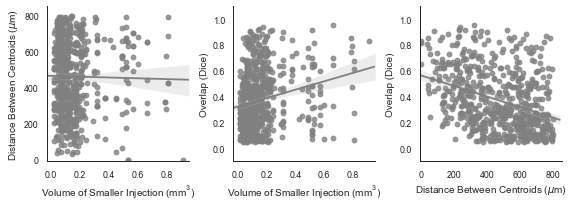

In [40]:
fig, ax = plt.subplots(1, 3, figsize = (8, 3))
sns.regplot('match_A_injection_size', 'distance', data = c_by_source, ax = ax[0], color='gray')
sns.regplot('match_A_injection_size', 'dice_coefficient', data = c_by_source, ax = ax[1],
           color = 'gray')
sns.regplot('distance', 'dice_coefficient', data = c_by_source, ax = ax[2], color = 'gray')
sns.despine()
ax[0].tick_params(top = False, right = False)
ax[1].tick_params(top = False, right = False)
ax[2].tick_params(top = False, right = False)
#ax[0].set_xlim([-0.05, 1])
#ax[1].set_xlim([-0.05, 1])
ax[2].set_xlim([-10, 850])
ax[0].set_ylim([-10, 850])
ax[1].set_ylim([-0.1, 1.1])
ax[2].set_ylim([-0.1, 1.1])
ax[0].set_ylabel('Distance Between Centroids ($\mu$m)', fontsize = 10)
ax[1].set_ylabel('Overlap (Dice)', fontsize = 10)
ax[2].set_ylabel('Overlap (Dice)', fontsize = 10)
ax[0].set_xlabel(r'Volume of Smaller Injection (mm$\mathregular{^{3}}$)', fontsize = 10)
ax[1].set_xlabel(r'Volume of Smaller Injection (mm$\mathregular{^{3}}$)', fontsize = 10)
ax[2].set_xlabel('Distance Between Centroids ($\mu$m)', fontsize = 10)
plt.tight_layout()
#plt.savefig(os.path.join(path, 'interdependence of distance volume overlap.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)

In [41]:
m, b, r1, p1, se = stats.linregress(c_by_source['match_A_injection_size'], 
                                    c_by_source['distance'])
m, b, r2, p2, se = stats.linregress(c_by_source['match_A_injection_size'], 
                                    c_by_source['dice_coefficient'])
m, b, r3, p3, se = stats.linregress(c_by_source['distance'], 
                                    c_by_source['dice_coefficient'])

fdrcorr = sm.stats.fdrcorrection([p1, p2, p3], alpha=0.05, method='indep')
print(fdrcorr)
print(r1, r2, r3)

(array([False,  True,  True]), array([6.71098792e-01, 7.27141050e-08, 1.54633616e-19]))
-0.01699118739390926 0.21578221741445353 -0.35459753276244915


In [42]:
c_by_source[(c_by_source['match_A_secondary_source'] == 'TEa') &
     (c_by_source['same secondary for <60% primary'] == True)][['match_A', 'match_B']]

,match_A,match_B
4444,606100558,579203888
4449,606100558,554421791


In [43]:
print(c_by_source['match_A_injection_size'].max())

0.90878975


In [44]:
c_by_source['transgenic_line_A'].unique()

array([nan, 'Rbp4-Cre_KL100', 'Emx1-IRES-Cre'], dtype=object)

In [45]:
A = c_by_source[['match_A_injection_size', 'transgenic_line_A']]
A.rename(columns = {'match_A_injection_size': 'injection_size',
                   'transgenic_line_A': 'transgenic_line'}, inplace = True)
B = c_by_source[['match_B_injection_size', 'transgenic_line_B']]
B.rename(columns = {'match_B_injection_size': 'injection_size',
                   'transgenic_line_B': 'transgenic_line'}, inplace = True)
TD = alldat[['td_injection_size']]
TD.rename(columns = {'td_injection_size': 'injection_size'}, inplace = True)
TD['transgenic_line'] = 'TD (Ai75(RCL-nt))'
pltdat = pd.concat([A,B,TD])
pltdat.loc[pltdat['transgenic_line'].isnull(), 'transgenic_line'] = 'C57Bl/6'

/opt/anaconda3/envs/DMN/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/opt/anaconda3/envs/DMN/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [46]:
pltdat['transgenic_line'].unique()

array(['C57Bl/6', 'Rbp4-Cre_KL100', 'Emx1-IRES-Cre', 'TD (Ai75(RCL-nt))'],
      dtype=object)

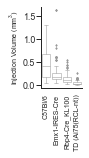

In [47]:
fig, ax = plt.subplots(figsize = (0.75, 1.5))
sns.boxplot('transgenic_line', 'injection_size', data = pltdat,
            order = ['C57Bl/6', 'Emx1-IRES-Cre', 'Rbp4-Cre_KL100', 'TD (Ai75(RCL-nt))'],
            color = 'w',
           linewidth = 0.5, fliersize = 1, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize = 7)
ax.set_ylabel('Injection Volume (mm$\mathregular{^{3}}$)', fontsize = 7)
ax.set_xlabel('', fontsize = 7)
ax.yaxis.labelpad = 1
ax.tick_params(left=True, bottom=False, pad=1)
sns.despine()
#plt.savefig(os.path.join(savepath, 'injection_volume_boxplot.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [48]:
formula = 'injection_size~C(transgenic_line)' 
model = ols(formula, pltdat).fit()
aov_table = anova_lm(model, typ=2)
aov_table.round(4)

,sum_sq,df,F,PR(>F)
C(transgenic_line),50.3295,3.0,420.6228,0.0
Residual,73.2287,1836.0,NaN,NaN


In [49]:
mc = MultiComparison(pltdat['injection_size'], 
                    pltdat['transgenic_line'])
mc_results = mc.tukeyhsd()
print(mc_results)

       Multiple Comparison of Means - Tukey HSD,FWER=0.05       
    group1           group2      meandiff  lower   upper  reject
----------------------------------------------------------------
   C57Bl/6       Emx1-IRES-Cre   -0.2152  -0.2506 -0.1798  True 
   C57Bl/6       Rbp4-Cre_KL100  -0.3154  -0.3502 -0.2807  True 
   C57Bl/6     TD (Ai75(RCL-nt)) -0.4073  -0.4378 -0.3768  True 
Emx1-IRES-Cre    Rbp4-Cre_KL100  -0.1003   -0.139 -0.0615  True 
Emx1-IRES-Cre  TD (Ai75(RCL-nt)) -0.1921  -0.2271 -0.1572  True 
Rbp4-Cre_KL100 TD (Ai75(RCL-nt)) -0.0919  -0.1262 -0.0575  True 
----------------------------------------------------------------


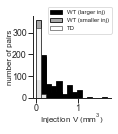

In [50]:
fig, ax = plt.subplots(figsize = (1.4, 1.5))
bins = np.linspace(0.01, 1.7, 15)
plt.hist(c_by_source['match_A_injection_size'].values, bins = bins,
         label = 'WT (smaller inj)', color = 'darkgray', edgecolor = 'k');
plt.hist(c_by_source['match_B_injection_size'].values, bins = bins,
         label = 'WT (larger inj)', color = 'k', edgecolor = 'k');
plt.hist(alldat['td_injection_size'].values, 
         bins = bins, alpha = 0.9,
         label = 'TD', color = 'w', linewidth = 0.5,
        edgecolor = 'k');
ax.set_ylabel('number of pairs', fontsize = 8)
ax.set_xlabel('Injection V (mm$\mathregular{^{3}}$)', fontsize = 8)
ax.xaxis.labelpad = -1
ax.yaxis.labelpad = -1
ax.tick_params(left=True, bottom=True, pad=1)
handles,labels = ax.get_legend_handles_labels()

handles = [handles[1], handles[0], handles[2]]
labels = [labels[1], labels[0], labels[2]]

ax.legend(handles,labels,
          loc = 1, fontsize = 6, bbox_to_anchor = [1.05, 1.15])
sns.despine()
#plt.savefig(os.path.join(savepath, 'injection_volume_histogram.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [51]:
alldat['td_injection_size'].quantile(0.1)

0.0020187070000000002

In [52]:
print(len(c_by_source))
len(c_by_source[c_by_source['match_A_injection_size'] < 0.25])

627


544

1.713243866892281e-07


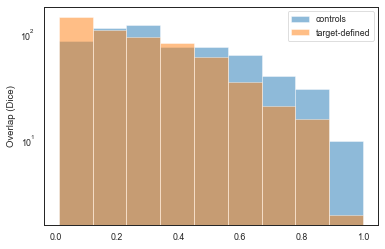

In [53]:
fig, ax = plt.subplots()
bins = np.linspace(0.01, 1, 10)
plt.hist(c_by_source['dice_coefficient'].values, bins = bins, alpha = 0.5, 
         label = 'controls');
plt.hist(alldat['dice'].values, bins = bins, alpha = 0.5, 
         label = 'target-defined');
ax.set_yscale('log')
ax.set_ylabel('Overlap (Dice)')
ax.legend()
_, p = stats.mannwhitneyu(c_by_source['dice_coefficient'].values, 
                       alldat['dice'].values)
print(p)

708.0202091
2.431533054164464e-45


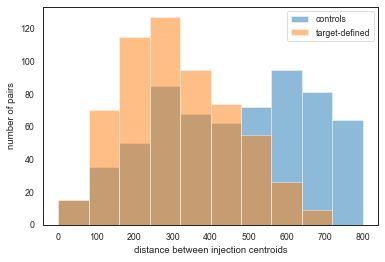

In [54]:
fig, ax = plt.subplots()
bins = np.linspace(0, 800, 11)
plt.hist(c_by_source['distance'].values, bins = bins, alpha = 0.5, label = 'controls');
plt.hist(alldat['distance'].values, bins = bins, alpha = 0.5, label = 'target-defined');
ax.set_ylabel('number of pairs')
ax.set_xlabel('distance between injection centroids')
ax.legend()
print(alldat['distance'].max())
_, p = stats.ttest_ind(c_by_source['distance'].values, 
                       alldat['distance'].values)
print(p)

## Fit model

/opt/anaconda3/envs/DMN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


size 0.24353116901304328


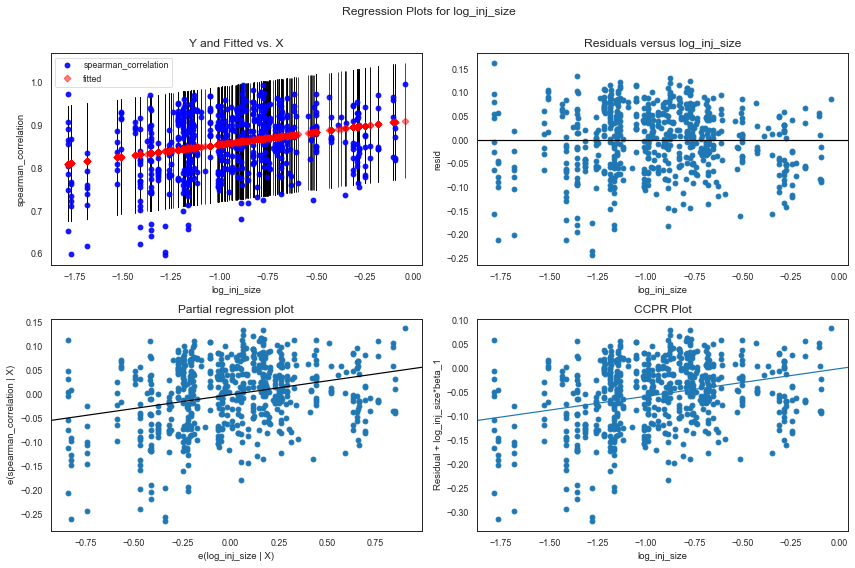

In [55]:
c_by_source['log_inj_size'] = np.log10(c_by_source['match_A_injection_size'])
X = c_by_source[['log_inj_size']]
X = sm.add_constant(X)
y = c_by_source[['spearman_correlation']]

# fit GLM
fit = sm.OLS(y, X).fit()
print('size', np.max([fit.resid.max(), abs(fit.resid.min())]))
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(fit, "log_inj_size", fig = fig)

In [56]:
print(fit.summary())

                             OLS Regression Results                             
Dep. Variable:     spearman_correlation   R-squared:                       0.082
Model:                              OLS   Adj. R-squared:                  0.081
Method:                   Least Squares   F-statistic:                     55.86
Date:                  Tue, 03 Nov 2020   Prob (F-statistic):           2.64e-13
Time:                          20:51:00   Log-Likelihood:                 793.33
No. Observations:                   627   AIC:                            -1583.
Df Residuals:                       625   BIC:                            -1574.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.9139     

2.9227072449143376


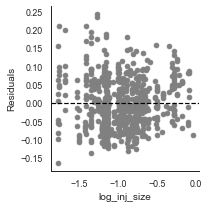

In [57]:
y_fit = fit.predict(X).values
resids = (y_fit-np.array([value[0] for value in y.values]))
fig, ax = plt.subplots(figsize = (3,3))
plt.scatter(c_by_source[['log_inj_size']], resids, c = 'gray')
plt.axhline(y=0, c='k', linestyle = '--')
sns.despine()
ax.tick_params(top = False, right = False)
ax.set_ylabel('Residuals', fontsize = 10)
ax.set_xlabel(r'log_inj_size', fontsize = 10)
plt.tight_layout()
#plt.savefig(os.path.join(path, 'log inj size linear fit residuals.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)
print(np.sum(resids**2))

/opt/anaconda3/envs/DMN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


size 0.2539355692557528


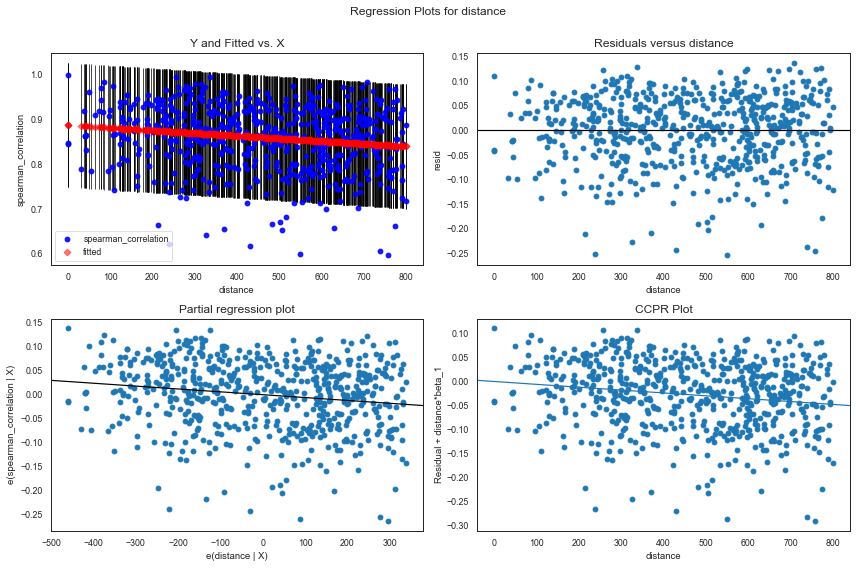

In [58]:
X = c_by_source[['distance']]
X = sm.add_constant(X)
y = c_by_source[['spearman_correlation']]

# fit GLM
fit = sm.OLS(y, X).fit()
print('size', np.max([fit.resid.max(), abs(fit.resid.min())]))
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(fit, "distance", fig = fig)

In [59]:
print(fit.summary())

                             OLS Regression Results                             
Dep. Variable:     spearman_correlation   R-squared:                       0.028
Model:                              OLS   Adj. R-squared:                  0.026
Method:                   Least Squares   F-statistic:                     17.96
Date:                  Tue, 03 Nov 2020   Prob (F-statistic):           2.60e-05
Time:                          20:51:02   Log-Likelihood:                 775.38
No. Observations:                   627   AIC:                            -1547.
Df Residuals:                       625   BIC:                            -1538.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8871      0.007

3.094968894334036


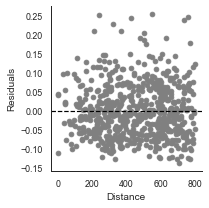

In [60]:
y_fit = fit.predict(X).values
resids = (y_fit-np.array([value[0] for value in y.values]))
fig, ax = plt.subplots(figsize = (3,3))
plt.scatter(c_by_source[['distance']], resids, c = 'gray')
plt.axhline(y=0, c='k', linestyle = '--')
sns.despine()
ax.tick_params(top = False, right = False)
ax.set_ylabel('Residuals', fontsize = 10)
ax.set_xlabel(r'Distance', fontsize = 10)
plt.tight_layout()
#plt.savefig(os.path.join(path, 'log inj size linear fit residuals.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)
print(np.sum(resids**2))

/opt/anaconda3/envs/DMN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


size 0.2676765347772896


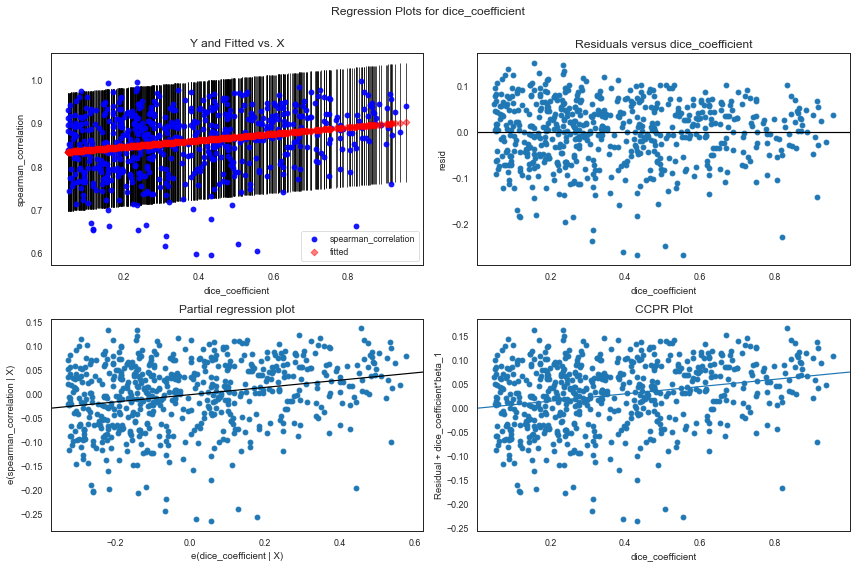

In [61]:
c_by_source['log_ol'] = np.log10(c_by_source['dice_coefficient'])
X = c_by_source[['dice_coefficient']]
X = sm.add_constant(X)
y = c_by_source[['spearman_correlation']]

# fit GLM
fit = sm.OLS(y, X).fit()
print('size', np.max([fit.resid.max(), abs(fit.resid.min())]))
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(fit, "dice_coefficient", fig = fig)

In [62]:
print(fit.summary())

                             OLS Regression Results                             
Dep. Variable:     spearman_correlation   R-squared:                       0.059
Model:                              OLS   Adj. R-squared:                  0.058
Method:                   Least Squares   F-statistic:                     39.49
Date:                  Tue, 03 Nov 2020   Prob (F-statistic):           6.17e-10
Time:                          20:51:04   Log-Likelihood:                 785.70
No. Observations:                   627   AIC:                            -1567.
Df Residuals:                       625   BIC:                            -1559.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               

2.994677660529941


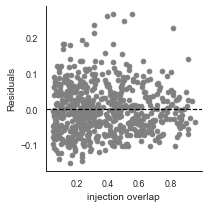

In [63]:
y_fit = fit.predict(X).values
resids = (y_fit-np.array([value[0] for value in y.values]))
fig, ax = plt.subplots(figsize = (3,3))
plt.scatter(c_by_source[['dice_coefficient']], resids, c = 'gray')
plt.axhline(y=0, c='k', linestyle = '--')
sns.despine()
ax.tick_params(top = False, right = False)
ax.set_ylabel('Residuals', fontsize = 10)
ax.set_xlabel(r'injection overlap', fontsize = 10)
plt.tight_layout()
#plt.savefig(os.path.join(path, 'log inj size linear fit residuals.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)
print(np.sum(resids**2))

In [64]:
def exp(x, a, b, c):
    return a * 10**(-x / b) + c

x1 = c_by_source['dice_coefficient'].values
x2 = c_by_source['distance'].values
x3 = c_by_source['match_A_injection_size'].values
Y = c_by_source['spearman_correlation'].values

p0 = -0.5, 0.1, 1
popt1, pcov1 = curve_fit(exp, x1, Y, p0) #overlap
yfit1=exp(x1, *popt1)
popt2, pcov2 = curve_fit(exp, x2, Y, p0) #distance
yfit2=exp(x2, *popt2)
popt3, pcov3 = curve_fit(exp, x3, Y, p0) #injection size
yfit3=exp(x3, *popt3)

n = len(x1)    # number of data points
p = len(popt1) # number of parameters
df = max(0, n-p) # number of degrees of freedom

# residual sum of squares
ss_res1 = np.sum((Y - yfit1) ** 2)
print('ss overlap')
print(ss_res1)
ss_res2 = np.sum((Y - yfit2) ** 2)
print('ss distance')
print(ss_res2)
ss_res3 = np.sum((Y - yfit3) ** 2)
print('ss injection size')
print(ss_res3)

# total sum of squares
ss_tot = np.sum((Y - np.mean(Y)) ** 2)

# r-squared
r21 = 1 - (ss_res1 / ss_tot)
print('r2 overlap')
print(r21)
r22 = 1 - (ss_res2 / ss_tot)
print('r2 distance')
print(r22)
r23 = 1 - (ss_res3 / ss_tot)
print('r2 injection size')
print(r23)

ss overlap
2.9946803099021113
ss distance
3.1798043994285896
ss injection size
2.8033317351828524
r2 overlap
0.05943311966303355
r2 distance
0.0012894885096859099
r2 injection size
0.1195317323214583


/opt/anaconda3/envs/DMN/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [65]:
# size vs size and distance
def exp0(x, a, b, c):
    return a * 10**(-x / b) + c

def exp1(X, a, b, c, d):
    x,y = X
    return a * 10**(-x / b) + (c * y) + d

x = c_by_source['match_A_injection_size'].values
y = c_by_source['distance'].values
Y = c_by_source['spearman_correlation'].values

popt_0, pcov_0 = curve_fit(exp0, x, Y)
popt_1, pcov_1 = curve_fit(exp1, (x,y), Y)

yfit0=exp0(x, *popt_0)
yfit1=exp1((x,y), *popt_1)

ssq0=((yfit0-Y)**2).sum()
ssq1=((yfit1-Y)**2).sum()

n = len(x)    # number of data points
p = len(popt_1) # number of parameters

df = max(0, n-p) # number of degrees of freedom

f_ratio=(ssq0-ssq1)/(ssq1/df)
p=1-stats.f.cdf(f_ratio, 1, df)

print(f_ratio, p)
print(popt_1)
print(ssq0)
print(ssq1)

ss_res = np.sum((Y - yfit1) ** 2)

# total sum of squares
ss_tot = np.sum((Y - np.mean(Y)) ** 2)

# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)

14.938708475036472 0.00012270871552166884
[-1.56409421e-01  9.06600645e-02 -5.15550402e-05  9.02426754e-01]
2.8033317357201675
2.7376856869659707
0.14014979247754245


In [66]:
# size vs size and overlap
def exp0(x, a, b, c):
    return a * 10**(-x / b) + c

def exp1(X, a, b, c, d):
    x,y = X
    return a * 10**(-x / b) + (c * y) + d

x = c_by_source['match_A_injection_size'].values
y = c_by_source['dice_coefficient'].values
Y = c_by_source['spearman_correlation'].values

popt_0, pcov_0 = curve_fit(exp0, x, Y)
popt_1, pcov_1 = curve_fit(exp1, (x,y), Y)

yfit0=exp0(x, *popt_0)
yfit1=exp1((x,y), *popt_1)

ssq0=((yfit0-Y)**2).sum()
ssq1=((yfit1-Y)**2).sum()

n = len(x)    # number of data points
p = len(popt_1) # number of parameters

df = max(0, n-p) # number of degrees of freedom

f_ratio=(ssq0-ssq1)/(ssq1/df)
p=1-stats.f.cdf(f_ratio, 1, df)

print(f_ratio, p)
print(popt_1)
print(ssq0)
print(ssq1)

ss_res = np.sum((Y - yfit1) ** 2)

# total sum of squares
ss_tot = np.sum((Y - np.mean(Y)) ** 2)

# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)

21.044174852145517 5.428000102392083e-06
[-0.14761972  0.0861677   0.05439157  0.85582903]
2.8033317357201675
2.7117327344115894
0.14830107578444263


In [67]:
# size and distance vs size, distance and overlap
def exp1(X, a, b, c, d):
    x,y = X
    return a * 10**(-x / b) + (c * y) + d
def exp2(X, a, b, c, d, e):
    x,y,z = X
    return a * 10**(-x / b) + (c * y) + (d * z) + e

x = c_by_source['match_A_injection_size'].values
y = c_by_source['distance'].values
y2 = c_by_source['dice_coefficient'].values
Y = c_by_source['spearman_correlation'].values

popt_1, pcov_1 = curve_fit(exp1, (x,y), Y)
popt_2, pcov_2 = curve_fit(exp2, (x,y,y2), Y)

yfit1=exp1((x,y), *popt_1)
yfit2=exp2((x,y,y2), *popt_2)

ssq1=((yfit1-Y)**2).sum()
ssq2=((yfit2-Y)**2).sum()

n = len(x)    # number of data points
p = len(popt_2) # number of parameters

df = max(0, n-p) # number of degrees of freedom

f_ratio=(ssq1-ssq2)/(ssq2/df)
p=1-stats.f.cdf(f_ratio, 1, df)

print(f_ratio, p)
print(ssq1)
print(ssq2)

ss_res = np.sum((Y - yfit2) ** 2)

# total sum of squares
ss_tot = np.sum((Y - np.mean(Y)) ** 2)

# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)
print(popt_2)

12.075071584452001 0.0005465430517924696
2.7376856869659707
2.685550297755293
0.15652443528094862
[-1.49862900e-01  8.48656898e-02 -3.46958205e-05  4.37213600e-02
  8.75721411e-01]


## Proceed with the best model

In [68]:
def exp(X, a, b, c, d, e):
    x,y,z = X
    return a * 10**(-x / b) + (c * y) + (d * z) + e
c_by_source.sort_values(by='match_A_injection_size', inplace = True)
x = c_by_source['match_A_injection_size'].values
y = c_by_source['distance'].values
y2 = c_by_source['dice_coefficient'].values
Y = c_by_source['spearman_correlation'].values

popt, pcov = curve_fit(exp, (x,y,y2), Y)

yfit=exp((x,y,y2), *popt)

resids = yfit-Y

ssq1=((yfit-Y)**2).sum()

n = len(x)    # number of data points
p = len(popt) # number of parameters

df = max(0, n-p) # number of degrees of freedom

ss_res = np.sum((Y - yfit) ** 2)

# total sum of squares
ss_tot = np.sum((Y - np.mean(Y)) ** 2)

# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)
print(ss_res)
print(popt)

0.15652443528190474
2.6855502977522487
[-1.49862876e-01  8.48657022e-02 -3.46958054e-05  4.37213721e-02
  8.75721400e-01]


In [69]:
ss_tot

3.1839100148085593

Text(0.5, 0, 'dice')

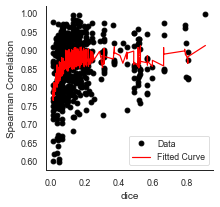

In [70]:
fig, ax = plt.subplots(figsize = (3,3))
plt.plot(x, Y, 'ko', label="Data")
plt.plot(x, exp((x,y,y2), *popt), 'r-', label="Fitted Curve")
plt.legend(loc = 4)
#ax.set_xlim([-0.01, 1])
sns.despine()
ax.tick_params(top = False, right = False)
ax.set_ylabel('Spearman Correlation', fontsize = 10)
ax.set_xlabel(r'dice', fontsize = 10)
#plt.savefig(os.path.join(path, 'inj size exponential fit with overlap.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)

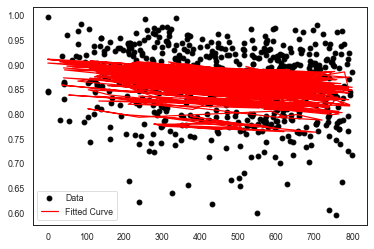

In [71]:
plt.plot(y, Y, 'ko', label="Data")
plt.plot(y, exp((x,y,y2), *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

Text(0.5, 0, 'spearman correlation')

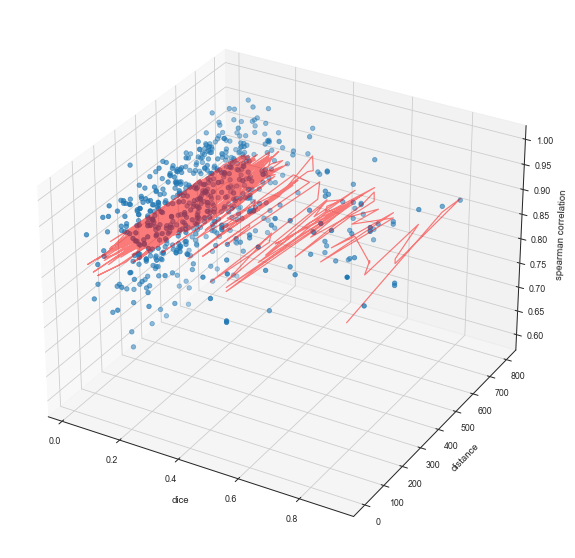

In [72]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, Y)
ax.plot(x, y, exp((x,y,y2), *popt), 'r-', alpha = 0.5, label="Fitted Curve")
ax.set_xlabel('dice')
ax.set_ylabel('distance')
ax.set_zlabel('spearman correlation')

Text(0.5, 0, 'spearman correlation')

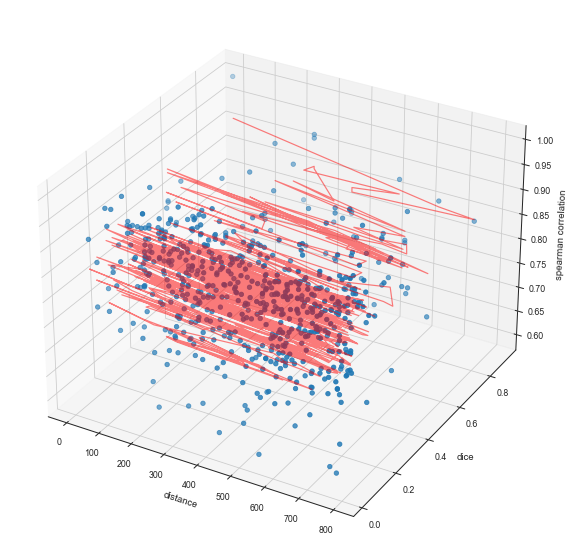

In [73]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y, x, Y)
ax.plot(y, x, exp((x,y,y2), *popt), 'r-', alpha = 0.5, label="Fitted Curve")
ax.set_xlabel('distance')
ax.set_ylabel('dice')
ax.set_zlabel('spearman correlation')

In [74]:
c_by_source['exp_predicted'] = exp((c_by_source['match_A_injection_size'].values,
                               c_by_source['distance'].values,
                                   c_by_source['dice_coefficient'].values), *popt)
alldat['exp_predicted'] = exp((alldat['td_injection_size'],
                               alldat['distance'].values,
                              alldat['dice'].values), *popt)

In [75]:
all_isids = np.unique(np.concatenate((c_by_source['match_A'].unique(), c_by_source['match_B'].unique())))
num_comparisons = []
pearson_corr = []
spearman_corr = []
sources = []
inj_sizes = []
dist = []
predicted_spearman = []
for isid in all_isids:
    if len(c_by_source[c_by_source['match_A'] == isid]['match_A_primary_source'].values) > 0:
        sources.append(c_by_source[c_by_source['match_A'] == isid]['match_A_primary_source'].values[0])
        inj_sizes.append(c_by_source[c_by_source['match_A'] == isid]['match_A_injection_size'].values[0])
    else:
        sources.append(c_by_source[c_by_source['match_B'] == isid]['match_B_primary_source'].values[0])
        inj_sizes.append(c_by_source[c_by_source['match_B'] == isid]['match_A_injection_size'].values[0])
    dataset = c_by_source[(c_by_source['match_A'] == isid) | (c_by_source['match_B'] == isid)]
    num_comparisons.append(len(dataset))
    pearson_corr.append(dataset['pearson_correlation'].mean())
    spearman_corr.append(dataset['spearman_correlation'].mean())
    predicted_spearman.append(dataset['exp_predicted'].mean())
    dist.append(dataset['distance'].mean())
cmeans = pd.DataFrame({'image_series_id': all_isids, 'source': sources, 
                       'number of comparisons': num_comparisons, 'mean_distance': dist,
                       'pearson_correlation': pearson_corr, 
                       'spearman_correlation': spearman_corr,
                      'predicted_spearman': predicted_spearman})
print(len(cmeans))

208


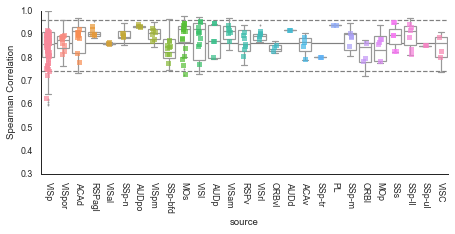

In [76]:
fig, ax = plt.subplots(figsize = (7.3, 3))
sns.boxplot('source', 'spearman_correlation', data = c_by_source, 
            color = 'white', order = c_by_source['source'].unique(), fliersize = 1)
sns.stripplot('source', 'spearman_correlation', data = cmeans, 
              alpha = 0.7, marker = 's', order = c_by_source['source'].unique())
plt.axhline(y=c_by_source['spearman_correlation'].mean(), 
            color = 'gray', zorder = -1)
plt.axhline(y=c_by_source['spearman_correlation'].quantile(0.95), 
            color = 'gray', linestyle = '--', zorder = -1)
plt.axhline(y=c_by_source['spearman_correlation'].quantile(0.05),
            color = 'gray', linestyle = '--', zorder = -1)
plt.xticks(rotation = -90);
ax.tick_params(right=False, top=False)
sns.despine()
ax.set_ylim([0.3, 1]);
ax.set_ylabel('Spearman Correlation');

In [77]:
cmeans[cmeans['spearman_correlation'] < c_by_source['spearman_correlation'].quantile(0.05)]

,image_series_id,source,number of comparisons,mean_distance,pearson_correlation,spearman_correlation,predicted_spearman
74,174361040,VISp,5,489.774962,0.952126,0.721906,0.856202
80,180916954,MOs,1,789.303490,0.901408,0.724879,0.852267
95,277713580,VISp,6,500.585455,0.918462,0.623777,0.821309


In [78]:
def predband(x, xd, yd, f_vars, conf=0.95):
    """
    Code adapted from Rodrigo Nemmen's post:
    http://astropython.blogspot.com.ar/2011/12/calculating-prediction-band-
    of-linear.html

    Calculates the prediction band of the regression model at the
    desired confidence level.

    Clarification of the difference between confidence and prediction bands:

    "The prediction bands are further from the best-fit line than the
    confidence bands, a lot further if you have many data points. The 95%
    prediction band is the area in which you expect 95% of all data points
    to fall. In contrast, the 95% confidence band is the area that has a
    95% chance of containing the true regression line."
    (from http://www.graphpad.com/guides/prism/6/curve-fitting/index.htm?
    reg_graphing_tips_linear_regressio.htm)

    Arguments:
    - x: array with x values to calculate the confidence band.
    - xd, yd: data arrays.
    - a, b, c: linear fit parameters.
    - conf: desired confidence level, by default 0.95 (2 sigma)

    References:
    1. http://www.JerryDallal.com/LHSP/slr.htm, Introduction to Simple Linear
    Regression, Gerard E. Dallal, Ph.D.
    """
    for ix, val in enumerate(xd):
        if all(x == val):
            index = ix
    alpha = 1. - conf    # Significance
    N = len(xd) * len(xd[index])          # data sample size
    var_n = len(f_vars)  # Number of variables used by the fitted function.

    # Quantile of Student's t distribution for p=(1 - alpha/2)
    q = stats.t.ppf(1. - alpha / 2., N - var_n)

    # Std. deviation of an individual measurement (Bevington, eq. 6.15)
    se = np.sqrt(1. / (N - var_n) * np.sum((yd - exp(xd, *f_vars)) ** 2))

    # Auxiliary definitions
    sx = (x - xd[0].mean()) ** 2
    sxd = np.sum((xd[0] - xd[index].mean()) ** 2)

    # Predicted values (best-fit model)
    yp = exp(xd, *f_vars)
    # Prediction band
    dy = q * se * np.sqrt(1. + (1. / N) + (sx / sxd))

    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy

    return lpb, upb

(0.0, 0.25)

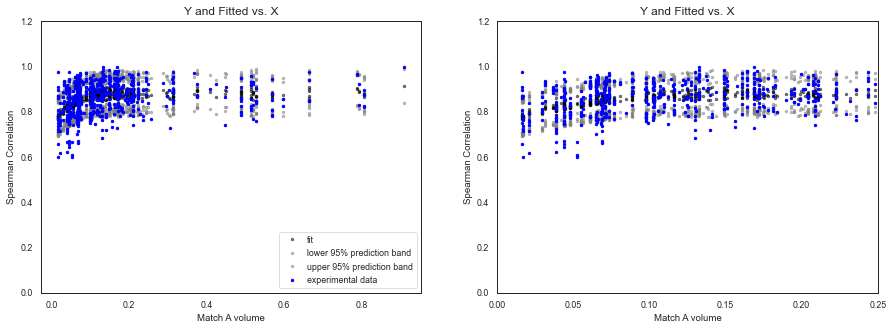

In [79]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].plot(c_by_source['match_A_injection_size'].values, c_by_source['exp_predicted'].values, '.', color='k', 
        label='fit',
        alpha=.5)
ax[0].plot(c_by_source['match_A_injection_size'].values, 
           predband(c_by_source['match_A_injection_size'].values,
                    (c_by_source['match_A_injection_size'].values, 
                     c_by_source['distance'].values, 
                     c_by_source['dice_coefficient'].values),
                    c_by_source['spearman_correlation'].values, popt)[0], 
        '.', color='gray', label='lower 95% prediction band',
        alpha=.5)
ax[0].plot(c_by_source['match_A_injection_size'].values, 
           predband(c_by_source['match_A_injection_size'].values,
                    (c_by_source['match_A_injection_size'].values, 
                    c_by_source['distance'].values, 
                    c_by_source['dice_coefficient'].values),
                    c_by_source['spearman_correlation'].values, popt)[1], 
        '.', color='gray', label='upper 95% prediction band', alpha=.5)
ax[0].plot(c_by_source['match_A_injection_size'].values, 
           c_by_source['spearman_correlation'].values, 
        '.', color='b',
       label = 'experimental data')
ax[0].set_title('Y and Fitted vs. X', fontsize='large')
ax[0].set_xlabel('Match A volume')
ax[0].set_ylabel('Spearman Correlation')
ax[0].set_ylim([0, 1.2])
ax[0].legend(loc=4)

ax[1].plot(c_by_source['match_A_injection_size'].values, 
           c_by_source['exp_predicted'].values, '.', color='k', 
        label='fit',
        alpha=.5)
ax[1].plot(c_by_source['match_A_injection_size'].values, 
           predband(c_by_source['match_A_injection_size'].values,
                    (c_by_source['match_A_injection_size'].values, 
                    c_by_source['distance'].values, 
                    c_by_source['dice_coefficient'].values),
                    c_by_source['spearman_correlation'].values, popt)[0], 
        '.', color='gray', label='lower 95% prediction band',
        alpha=.5)
ax[1].plot(c_by_source['match_A_injection_size'].values,
           predband(c_by_source['match_A_injection_size'].values,
                    (c_by_source['match_A_injection_size'].values, 
                    c_by_source['distance'].values, 
                    c_by_source['dice_coefficient'].values),
                    c_by_source['spearman_correlation'].values, popt)[1], 
        '.', color='gray', label='upper 95% prediction band',
        alpha=.5)
ax[1].plot(c_by_source['match_A_injection_size'].values, 
           c_by_source['spearman_correlation'].values, 
        '.', color='b',
       label = 'experimental data')
ax[1].set_title('Y and Fitted vs. X', fontsize='large')
ax[1].set_xlabel('Match A volume')
ax[1].set_ylabel('Spearman Correlation')
ax[1].set_ylim([0, 1.2])
ax[1].set_xlim([0, 0.25])

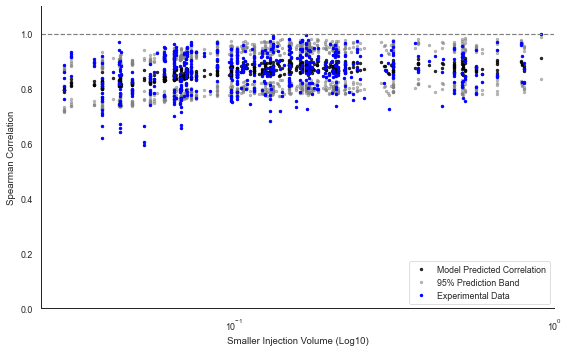

In [80]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(c_by_source['match_A_injection_size'].values, 
        c_by_source['exp_predicted'].values, '.', color='k', 
        label='Model Predicted Correlation',
        alpha=.8)
ax.plot(c_by_source['match_A_injection_size'].values, 
        predband(c_by_source['match_A_injection_size'].values,
                (c_by_source['match_A_injection_size'].values, 
                c_by_source['distance'].values,
                 c_by_source['dice_coefficient'].values),
                c_by_source['spearman_correlation'].values, popt)[0], 
        '.', color='gray', label='95% Prediction Band',
        alpha=.5)
ax.plot(c_by_source['match_A_injection_size'].values, 
        predband(c_by_source['match_A_injection_size'].values,
                (c_by_source['match_A_injection_size'].values, 
                c_by_source['distance'].values,
                 c_by_source['dice_coefficient'].values),
                c_by_source['spearman_correlation'].values, popt)[1], 
        '.', color='gray',
        alpha=.5)
ax.plot(c_by_source['match_A_injection_size'].values, 
        c_by_source['spearman_correlation'].values, 
        '.', color='b',
       label = 'Experimental Data')
ax.set_xlabel('Smaller Injection Volume (Log10)')
ax.set_ylabel('Spearman Correlation')
ax.set_xscale('log')
ax.set_xlim([0.025, 1])
ax.set_ylim([0, 1.1])
plt.axhline(y=1, color = 'gray', linestyle = '--')
ax.legend(loc=4)
sns.despine()
ax.tick_params(top=False, right=False)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
plt.tight_layout()
#plt.savefig(os.path.join(path, 'data with prediction bands.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)

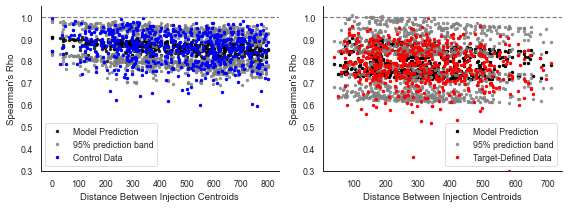

In [81]:
fig, ax = plt.subplots(1, 2, figsize = (8, 3))
ax[0].plot(c_by_source['distance'].values, 
           c_by_source['exp_predicted'].values, '.', color='k', 
           label='Model Prediction', alpha=0.8)
ax[0].plot(c_by_source['distance'].values, 
           predband(c_by_source['distance'].values,
                    (c_by_source['match_A_injection_size'].values,
                     c_by_source['distance'].values,
                     c_by_source['dice_coefficient'].values),
                    c_by_source['spearman_correlation'].values, popt)[0], '.', 
           color='gray', 
                    alpha=0.8)
ax[0].plot(c_by_source['distance'].values, 
           predband(c_by_source['distance'].values,
                    (c_by_source['match_A_injection_size'].values, 
                     c_by_source['distance'].values,
                     c_by_source['dice_coefficient'].values),
                    c_by_source['spearman_correlation'].values, popt)[1], '.', color='gray', 
                    label='95% prediction band', alpha=0.8)
ax[0].plot(c_by_source['distance'].values, 
           c_by_source['spearman_correlation'].values, '.', color='b', label = 'Control Data')
ax[0].set_xlabel('Distance Between Injection Centroids')
ax[0].set_ylabel('Spearman\'s Rho')
ax[0].set_ylim([0.3, 1.05])
ax[0].axhline(y=1, color = 'gray', linestyle = '--')
ax[0].legend(loc=3)
ax[0].tick_params(top=False, right=False)
ax[0].get_xaxis().set_tick_params(which='minor', size=0)
ax[0].get_xaxis().set_tick_params(which='minor', width=0) 

ax[1].plot(alldat['distance'].values, alldat['exp_predicted'].values,
       '.', color = 'k', label = 'Model Prediction')
ax[1].plot(alldat['distance'].values, 
           predband(alldat['distance'].values,
                    (alldat['td_injection_size'].values,
                     alldat['distance'].values,
                     alldat['dice'].values),
                    alldat['spearman_correlation'].values, popt)[0], '.', color='gray', 
                    alpha=0.8)
ax[1].plot(alldat['distance'].values, predband(alldat['distance'].values,
                    (alldat['td_injection_size'].values, 
                     alldat['distance'].values,
                     alldat['dice'].values),
                    alldat['spearman_correlation'].values, popt)[1], '.', color='gray', 
                    label='95% prediction band', alpha=0.8)
ax[1].plot(alldat['distance'].values, alldat['spearman_correlation'].values, 
       '.', color = 'r', label = 'Target-Defined Data')
ax[1].set_xlabel('Distance Between Injection Centroids')
ax[1].set_ylabel('Spearman\'s Rho')
ax[1].set_ylim([0.3, 1.05])
plt.axhline(y=1, color = 'gray', linestyle = '--')
ax[1].legend(loc=4)
sns.despine()
ax[1].tick_params(top=False, right=False)
ax[1].get_xaxis().set_tick_params(which='minor', size=0)
ax[1].get_xaxis().set_tick_params(which='minor', width=0) 
plt.tight_layout()
#plt.savefig(os.path.join(path, 'data with prediction bands plotted by distance.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)

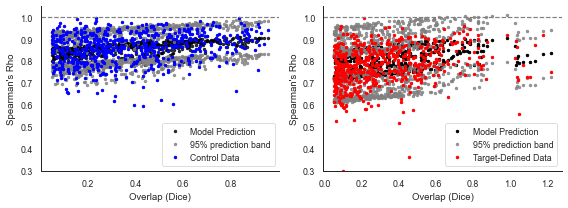

In [82]:
fig, ax = plt.subplots(1, 2, figsize = (8, 3))
ax[0].plot(c_by_source['dice_coefficient'].values, 
           c_by_source['exp_predicted'].values, '.', color='k', 
           label='Model Prediction', alpha=0.8)
ax[0].plot(c_by_source['dice_coefficient'].values, 
           predband(c_by_source['dice_coefficient'].values,
                    (c_by_source['match_A_injection_size'].values,
                     c_by_source['distance'].values,
                     c_by_source['dice_coefficient'].values),
                    c_by_source['spearman_correlation'].values, popt)[0], '.', color='gray', 
                    alpha=0.8)
ax[0].plot(c_by_source['dice_coefficient'].values, 
           predband(c_by_source['dice_coefficient'].values,
                    (c_by_source['match_A_injection_size'].values, 
                     c_by_source['distance'].values,
                     c_by_source['dice_coefficient'].values),
                    c_by_source['spearman_correlation'].values, popt)[1], '.', color='gray', 
                    label='95% prediction band', alpha=0.8)
ax[0].plot(c_by_source['dice_coefficient'].values, 
           c_by_source['spearman_correlation'].values, '.', color='b', label = 'Control Data')
ax[0].set_xlabel('Overlap (Dice)')
ax[0].set_ylabel('Spearman\'s Rho')
ax[0].set_ylim([0.3, 1.05])
ax[0].axhline(y=1, color = 'gray', linestyle = '--')
ax[0].legend(loc=4)
ax[0].tick_params(top=False, right=False)
ax[0].get_xaxis().set_tick_params(which='minor', size=0)
ax[0].get_xaxis().set_tick_params(which='minor', width=0) 

ax[1].plot(alldat['dice'].values, alldat['exp_predicted'].values,
       '.', color = 'k', label = 'Model Prediction')
ax[1].plot(alldat['dice'].values, 
           predband(alldat['dice'].values,
                    (alldat['td_injection_size'].values,
                     alldat['distance'].values,
                     alldat['dice'].values),
                    alldat['spearman_correlation'].values, popt)[0], '.', color='gray', 
                    alpha=0.8)
ax[1].plot(alldat['dice'].values, 
           predband(alldat['dice'].values,
                    (alldat['td_injection_size'].values, 
                     alldat['distance'].values,
                     alldat['dice'].values),
                    alldat['spearman_correlation'].values, popt)[1], '.', color='gray', 
                    label='95% prediction band', alpha=0.8)
ax[1].plot(alldat['dice'].values, 
           alldat['spearman_correlation'].values, 
       '.', color = 'r', label = 'Target-Defined Data')
ax[1].set_xlabel('Overlap (Dice)')
ax[1].set_ylabel('Spearman\'s Rho')
ax[1].set_ylim([0.3, 1.05])
plt.axhline(y=1, color = 'gray', linestyle = '--')
ax[1].legend(loc=4)
sns.despine()
ax[1].tick_params(top=False, right=False)
ax[1].get_xaxis().set_tick_params(which='minor', size=0)
ax[1].get_xaxis().set_tick_params(which='minor', width=0) 
plt.tight_layout()
#plt.savefig(os.path.join(path, 'data with prediction bands plotted by overlap.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)

In [83]:
x,y = c_by_source['match_A_injection_size'].values, predband(
    c_by_source['match_A_injection_size'].values, 
    (c_by_source['match_A_injection_size'].values, 
     c_by_source['distance'].values,
     c_by_source['dice_coefficient'].values),
    c_by_source['spearman_correlation'].values, popt)[0]

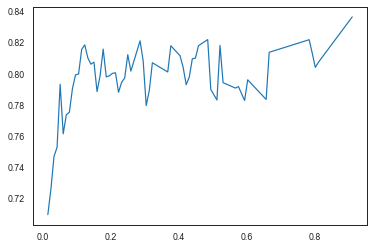

In [84]:
from scipy.interpolate import make_interp_spline, BSpline
xnew = np.linspace(x.min(),x.max(), 100) #300 represents number of points to make between T.min and T.max
spl = make_interp_spline(x, y, k=1) #BSpline object
power_smooth = spl(xnew)

plt.plot(xnew,power_smooth)
plt.show()

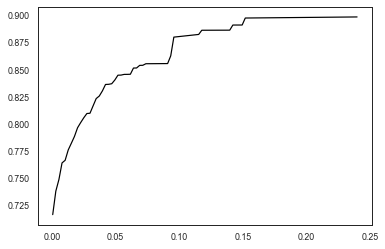

In [85]:
fig, ax = plt.subplots()
x = alldat['td_injection_size'].sort_values()
y = alldat['exp_predicted'].sort_values()
xnew = np.linspace(x.min(),x.max(), 100)
spl = make_interp_spline(x, y, k=1) #BSpline object
ax.plot(xnew[:-1], spl(xnew)[:-1], color='k', label='Model Prediction')

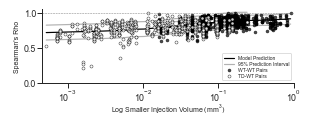

In [96]:
fig, ax = plt.subplots(figsize = (4.5, 1.9))

# WT model prediction
x = c_by_source['match_A_injection_size'].sort_values()
y = c_by_source['exp_predicted'].sort_values()
xnew = np.linspace(x.min(),x.max(), 100)
spl = make_interp_spline(x, y, k=1) #BSpline object
ax.plot(xnew, spl(xnew), color='k', label='Model Prediction')

# prediction bands
pband = predband(
    c_by_source['match_A_injection_size'].values, 
    (c_by_source['match_A_injection_size'].values, 
     c_by_source['distance'].values,
     c_by_source['dice_coefficient'].values),
    c_by_source['spearman_correlation'].values, popt)

# Top band
x = c_by_source['match_A_injection_size'].values
y = pband[0]
x.sort()
y.sort()
xnew = np.linspace(x.min(),x.max(), 100)
spl = make_interp_spline(x, y, k=1) #BSpline object
ax.plot(xnew, spl(xnew), color='gray', 
        label='95% Prediction Interval', alpha=0.6, zorder = -1)
#bottom band
y = pband[1]
y.sort()
spl = make_interp_spline(x, y, k=1) #BSpline object
ax.plot(xnew, spl(xnew), color='gray',  
        alpha=0.6, zorder = -1)

#wt experimental values
ax.plot(c_by_source['match_A_injection_size'].values, 
           c_by_source['spearman_correlation'].values, '.', color='k', 
        markeredgecolor = 'k', markeredgewidth = 0.5, markersize = 6, 
        label = 'WT-WT Pairs', alpha = 0.7, rasterized = True)

#TD predictions
x = alldat['td_injection_size'].sort_values()
y = alldat['exp_predicted'].sort_values()
xnew = np.linspace(x.min(),x.max(), 100)
spl = make_interp_spline(x, y, k=1) #BSpline object
# spl is having an edge effect. This is not in the data, just removing
# the point from the plot because it is a smoothing artifact
ax.plot(xnew[:-1], spl(xnew)[:-1], color='k')
      
#TD upper prediction interval
pband = predband(alldat['td_injection_size'].values,
                (alldat['td_injection_size'].values,
                alldat['distance'].values,
                alldat['dice'].values),
                alldat['spearman_correlation'].values, popt)
x = alldat['td_injection_size'].sort_values()
y=pband[0]
y.sort()
xnew = np.linspace(x.min(),x.max(), 100)
spl = make_interp_spline(x, y, k=1) #BSpline object
# same thing with the smoothing artifact
ax.plot(xnew[:-1], spl(xnew)[:-1], color='gray', alpha=0.6, zorder = -1)

#TD lower prediction interval
y=pband[1]
y.sort()
spl = make_interp_spline(x, y, k=1) #BSpline object
# same thing with the smoothing artifact
ax.plot(xnew[:-1], spl(xnew)[:-1], color='gray', alpha=0.6, zorder = -1)

#TD experimental values
ax.plot(alldat['td_injection_size'].values, 
        alldat['spearman_correlation'].values, 
       '.', color = 'w', alpha = 0.8, label = 'TD-WT Pairs',
        markeredgecolor = 'k', markeredgewidth = 0.5, markersize = 6,
       rasterized = True)

ax.set_xlabel('Log Smaller Injection Volume (mm$\mathregular{^{3}}$)', labelpad = -1,
             fontsize = 7)
ax.set_ylabel('Spearman\'s Rho', fontsize = 7)
ax.set_xscale('log')
ax.set_xlim([0.00045, 1])
ax.set_ylim([0, 1.05])
ax.xaxis.labelpad = -2
plt.axhline(y=1, color = 'gray', linestyle = '--', linewidth = 0.5)
ax.legend(loc=4, labelspacing = 0.2, fontsize = 5)
sns.despine()
ax.tick_params(top=False, right=False, left=True, bottom=True, pad=1)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
plt.tight_layout()
savepath = r'/Users/jenniferwh/Dropbox (Personal)/2019 DMN/_Manuscript drafts/JW_working/_final_figures/Figure_S6'
plt.savefig(os.path.join(savepath, 'data with prediction bands plotted by inj volume.pdf'), 
            bbox_inches='tight', format='pdf', transparent = True, dpi=300)

In [91]:
len([isid for isid in alldat['match_id'].unique() if 
 isid not in c_by_source['match_A'].unique() and isid not in c_by_source['match_B'].unique()])

20

In [92]:
low_pred_band = pd.DataFrame()
high_pred_band = pd.DataFrame()
for key in ['td_injection_size', 'distance', 'dice']:
    low_pred_band[key] = predband(alldat[key].values, 
                                       (alldat['td_injection_size'].values, 
                                        alldat['distance'].values,
                                        alldat['dice'].values), 
                                       alldat['spearman_correlation'].values, popt)[0]
    high_pred_band[key] = predband(alldat[key].values, 
                                       (alldat['td_injection_size'].values, 
                                        alldat['distance'].values,
                                        alldat['dice'].values), 
                                       alldat['spearman_correlation'].values, popt)[1]

In [93]:
## SSp-bfd experiment
exp((0.001888, 271.5,0), *popt)
#predband(0.001888, (0.001888, 271.5, 0), 0.872, popt)

0.7239220918080909

In [94]:
alldat['low_pred_band'] = low_pred_band.min(axis = 1).values
alldat['high_pred_band'] = high_pred_band.max(axis = 1).values

In [95]:
print(len(alldat[alldat['spearman_correlation'] < alldat['exp_predicted']]))
print(len(alldat[alldat['spearman_correlation'] < alldat['low_pred_band']]['image_series_id'].unique()))
print(len(alldat))
alldat[alldat['spearman_correlation'] < alldat['low_pred_band']]['source'].unique()

312
26
586


array(['ORBvl', 'ACAv', 'VISl', 'VISp', 'ORBl', 'RSPv', 'MOs', 'PL',
       'ORBm'], dtype=object)

In [96]:
for isid in alldat[alldat['spearman_correlation'] < alldat['low_pred_band']]['image_series_id'].unique():
    print(isid)
    print(alldat[alldat['image_series_id'] == isid]['source'].unique())
    print(len(alldat[alldat['image_series_id'] == isid]))
    print(len(alldat[(alldat['image_series_id'] == isid) &
                 (alldat['spearman_correlation'] < alldat['low_pred_band'])]))

526783792
['ORBvl']
3
2
569932566
['ACAv']
2
1
617898760
['ORBvl']
5
5
501883865
['VISl']
8
2
532005897
['ORBvl']
4
3
501837158
['VISp']
7
4
561918178
['VISp']
23
16
623286726
['ACAv']
3
1
636799953
['ORBl']
4
3
501711996
['VISp']
20
11
601804603
['ORBl']
2
2
515920693
['VISp']
15
3
565146821
['VISp']
17
2
501786400
['VISp']
17
6
592522663
['RSPv']
1
1
502956560
['VISl']
7
1
501785691
['VISl']
6
2
607052300
['ACAv']
2
2
504176074
['VISl']
7
5
502955689
['VISl']
9
1
569993539
['MOs']
1
1
539511058
['VISp']
12
2
575683857
['PL']
2
1
523177830
['ORBvl']
5
1
524267323
['ORBm']
2
1
868641659
['RSPv']
1
1


In [97]:
len(alldat[(alldat['source'] == 'RSPv') & (alldat['spearman_correlation'] < alldat['low_pred_band'])])

2

In [98]:
alldat[(alldat['source'] == 'RSPv') & (alldat['spearman_correlation'] < alldat['low_pred_band'])]

,distance,exclusion_zone_overlap,fraction of match covered by td exclusion zone,fraction of match covered by td injection,image_series_id,injection_overlap,match_id,pearson_correlation,source,spearman_correlation,...,injection_size_ratio,Julie call,PN_type_JH,JW_pass-fail,dice,include,CAV_percent_DMN,exp_predicted,low_pred_band,high_pred_band
795,309.266574,0.191553,0.336906,0.031516,592522663,0.421307,112595376,0.90832,RSPv,0.527093,...,172.062089,Y,IT PT CT,good,0.062609,yes,97.94051,0.719958,0.614106,0.825810
1319,131.845400,0.250604,0.700805,0.160533,868641659,0.797123,112595376,0.90473,RSPv,0.235626,...,43.605917,NaN,NaN,NaN,0.316008,yes,NaN,0.743188,0.637337,0.849039


In [99]:
low_pred = pd.DataFrame()
high_pred = pd.DataFrame()
for key in ['match_A_injection_size', 'distance', 'dice_coefficient']:
    low_pred[key] = predband(c_by_source[key].values, 
                                       (c_by_source['match_A_injection_size'].values, 
                                        c_by_source['distance'].values,
                                        c_by_source['dice_coefficient'].values), 
                                       c_by_source['spearman_correlation'].values, popt)[0]
    high_pred[key] = predband(c_by_source[key].values, 
                                       (c_by_source['match_A_injection_size'].values, 
                                        c_by_source['distance'].values,
                                        c_by_source['dice_coefficient'].values), 
                                       c_by_source['spearman_correlation'].values, popt)[1]
c_by_source['low_pred_band'] = low_pred.min(axis = 1).values
c_by_source['high_pred_band'] = high_pred.max(axis = 1).values

In [100]:
c_by_source['sig'] = c_by_source['spearman_correlation'] < c_by_source['low_pred_band']
len(c_by_source[c_by_source['spearman_correlation'] < c_by_source['low_pred_band']])

79

In [101]:
c_by_source[c_by_source['spearman_correlation'] < c_by_source['low_pred_band']]['source'].unique()

array(['VISp', 'SSp-bfd', 'VISl', 'MOs', 'ACAd', 'SSp-tr', 'ORBl', 'MOp',
       'VISpor', 'ACAv', 'RSPv', 'VISC'], dtype=object)

In [102]:
[source for source in c_by_source[c_by_source['sig']]['source'].unique() if source \
 not in alldat['source'].unique()]

['SSp-bfd', 'MOp', 'VISC']

In [104]:
[source for source in alldat['source'].unique() if source not in c_by_source['source'].unique()]

['VISa', 'ORBm', 'RSPd', 'ILA', 'VISli', 'ECT']

In [105]:
float(len(alldat[alldat['spearman_correlation'] < alldat['low_pred_band']][[
    'source', 'image_series_id', 'spearman_correlation']]))/len(alldat)

0.13651877133105803

In [106]:
float(len(c_by_source[c_by_source['spearman_correlation'] < c_by_source['low_pred_band']][[
    'source', 'match_A', 'spearman_correlation']]))/len(c_by_source)

0.12599681020733652

## Find mean per experiment for control data

In [107]:
# Checking for duplicates
isid = 535692871
len(c_by_source[c_by_source['match_A'] == isid]['match_A_primary_source'].values)
dataset = c_by_source[(c_by_source['match_A'] == isid) | (
        c_by_source['match_B'] == isid)]
dataset[['match_A', 'match_B']]

,match_A,match_B
2698,522409371,535692871
3373,121510421,535692871
3375,503323656,535692871
445,100147853,535692871
934,535692871,113887868
1984,535692871,307593747
273,535692871,307297141
529,535692871,307321674
1453,535692871,307137980
2880,535692871,500837552


In [108]:
all_isids = np.unique(np.concatenate(
    (c_by_source['match_A'].unique(), c_by_source['match_B'].unique())))
num_comparisons = []
corr = []
predicted_corr = []
sources = []
inj_sizes = []
mean_ol = []
mean_dist = []
mean_low_pred = []
mean_high_pred = []
frac_low_corr = []
for isid in all_isids:
    if len(c_by_source[c_by_source['match_A'] == isid]['match_A_primary_source'].values) > 0:
        sources.append(c_by_source[c_by_source['match_A'] == isid][
            'match_A_primary_source'].values[0])
        inj_sizes.append(c_by_source[c_by_source['match_A'] == isid][
            'match_A_injection_size'].values[0])
    else:
        sources.append(c_by_source[c_by_source['match_B'] == isid][
            'match_B_primary_source'].values[0])
        inj_sizes.append(c_by_source[c_by_source['match_B'] == isid][
            'match_A_injection_size'].values[0])
    dataset = c_by_source[(c_by_source['match_A'] == isid) | (
        c_by_source['match_B'] == isid)]
    
    num_comparisons.append(len(dataset))
    frac_low_corr.append(
        len(dataset[dataset['spearman_correlation'] < dataset['low_pred_band']])/len(dataset))
    corr.append(dataset['spearman_correlation'].mean())
    predicted_corr.append(dataset['exp_predicted'].mean())
    mean_ol.append(dataset['dice_coefficient'].mean())
    mean_dist.append(dataset['distance'].mean())
    mean_low_pred.append(dataset['low_pred_band'].min())
    mean_high_pred.append(dataset['high_pred_band'].max())

In [109]:
cmeans = pd.DataFrame({'image_series_id': all_isids, 'source': sources, 
                       'injection_size': inj_sizes, 'number_comparisons': num_comparisons, 
                       'fraction_low_corr': frac_low_corr,
                       'spearman_correlation': corr, 'exp_predicted': predicted_corr,
                      'mean_overlap': mean_ol, 'mean_distance': mean_dist, 
                       'low_pred': mean_low_pred})
print(len(cmeans))

208


<AxesSubplot:xlabel='fraction_low_corr'>

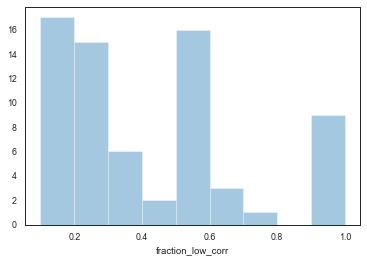

In [110]:
bins = np.linspace(0.1, 1, 10)
sns.distplot(cmeans['fraction_low_corr'], bins=bins, kde=False)

In [111]:
len(cmeans[cmeans['spearman_correlation'] < cmeans['low_pred']])

12

In [112]:
len(cmeans[cmeans['fraction_low_corr'] > 0.5])

13

In [113]:
cmeans[cmeans['spearman_correlation'] < cmeans['low_pred']]['source'].unique()

array(['MOs', 'SSp-tr', 'MOp', 'VISC', 'VISp', 'ACAv', 'ACAd'],
      dtype=object)

In [114]:
cmeans[cmeans['fraction_low_corr'] > 0.5]['source'].unique()

array(['SSp-tr', 'MOp', 'VISp', 'MOs', 'ACAv', 'VISl', 'ACAd', 'SSp-bfd'],
      dtype=object)

In [115]:
cmeans[cmeans['fraction_low_corr'] > 0.5]['number_comparisons'].unique()

array([1, 2, 5, 6, 4, 3])

In [116]:
cmeans['number_comparisons'].mean()

6.028846153846154

<AxesSubplot:xlabel='number_comparisons'>

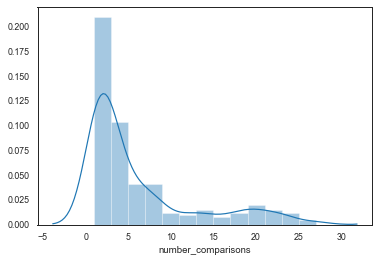

In [117]:
sns.distplot(cmeans['number_comparisons'])

## Find mean per experiment for target-defined data

In [118]:
meandat = alldat.groupby('image_series_id')[['spearman_correlation', 
                                             'exp_predicted', 
                                             'low_pred_band',
                                            'CAV_percent_DMN']].mean().reset_index()
meandat['number of comparisons'] = alldat.groupby('image_series_id')[
    'match_id'].count().values
for isid in meandat['image_series_id']:
    dataset = alldat[alldat['image_series_id'] == isid]
    meandat.loc[meandat['image_series_id'] == isid, 'source'] = alldat[
        alldat['image_series_id'] == isid]['source'].unique()[0]
    meandat.loc[meandat['image_series_id'] == isid, 'injection_size'] = alldat[
        alldat['image_series_id'] == isid]['td_injection_size'].unique()[0]
    meandat.loc[meandat['image_series_id'] == isid, 'fraction_low_corr'] = len(
        dataset[dataset['spearman_correlation'] < dataset['low_pred_band']])/len(dataset)
    meandat.loc[meandat['image_series_id'] == isid, 'mean_overlap'] = alldat[
        alldat['image_series_id'] == isid]['dice'].mean()
    meandat.loc[meandat['image_series_id'] == isid, 'low_pred_band'] = alldat[
        alldat['image_series_id'] == isid]['low_pred_band'].min()

In [119]:
len(meandat)

110

In [120]:
meansig = meandat[meandat['fraction_low_corr'] > 0.5]

In [121]:
len(meansig)

13

In [122]:
meansig['source'].unique()

array(['VISp', 'VISl', 'ORBvl', 'MOs', 'RSPv', 'ORBl', 'ACAv'],
      dtype=object)

In [123]:
meandat = meandat.merge(td_dataset[['image_series_id', 'target_by_polygon']], on = 'image_series_id',
                       how = 'left')
meandat.loc[meandat['image_series_id'].isin(meansig['image_series_id'].values), 
            'low_corr_experiment'] = True

In [124]:
#meandat.to_csv(os.path.join(datpath, 'td_mean_corr_dat.csv'), index = False)

In [125]:
#alldat.to_csv(os.path.join(datpath, 'good_td_wt_correlations.csv'), index = False)
#c_by_source.to_csv(os.path.join(datpath, 'good_wt_correlations.csv'), index = False)

In [126]:
c_by_source.groupby('source')['sum_NPV_A'].count().median()

5.0

In [127]:
len(alldat)

586

In [128]:
full_td_dataset['WT_matches'] = full_td_dataset['WT_matches'].astype('object')
matches = []
for isid in full_td_dataset['image_series_id'].unique():
    if len(alldat[
        alldat['image_series_id'] == isid]['match_id'].unique()) > 0:
        matches.append(list(alldat[
            alldat['image_series_id'] == isid]['match_id'].unique()))
    else:
        matches.append(list([np.nan]))
full_td_dataset['WT_matches'] = matches

In [129]:
#full_td_dataset.to_csv(os.path.join(datpath, 'target_defined_dataset.csv',
#                      index = False)